# coding attention mechanisms 

### The problem with modeling long sequences 

Lets go through some pre-LLM archs which do not include the attention mechanisms. Suppose we wanted to build the langauge translation model having encoder and decoder like structure is very common in deep neural network. 

Encoder read the entire text and understand it and decoder produces the translated text. 

Before the transformer era there was [RNN](03-sequence-modeling/01-rnn/rnn.ipynb) based encoder and decoder archs. It performs well on small size of translation. cause it suffers from long contextual dependencies. So whenver the lenght of senteces increase it loses the context. Due to it can translate text into gibberish lan. 

WHY-> cause it was uable to access the hidden state of the previous cell due to it was onlt able to generate the text based on current state. LSTM handle this with horizontal context line to some extend.(which carries the context from previous block to next block)

the working of rnn can be defined as : it takes the complete input into hidden state and decoder takes its hidden state to produce translated text.(hidden state is like understanding of text in number like embedding).

### Capturing data dependencies with attention mechanisms


RNN needs to remember the entire sentence in single go.(in hidden state). To overcome this researcher developed the Bahdanau attention mechanism for RNNs, which modifies the encoder–decoder RNN such that the decoder can selectively access different parts of the input sequence at each decoding step. Due to this it gets the context of the previous and also the past texts. 

So after few year of using attention in rnn the reasearcher realise that the rnn is no more required in attention mech. Then some reaercher introduces the 

### Attending to different parts of the input with self-attention

The self in self-attetion is cause it realates the single input sequence to all the other part of sentence to get the context of over all input. This is in contrast to traditional attention mechanisms, where the focus is on the relationships between elements of two different sequences, such as in sequence-to-sequence models where the attention might be between an input sequence and an output sequence

> A simple self-attention mechanism without trainable weights


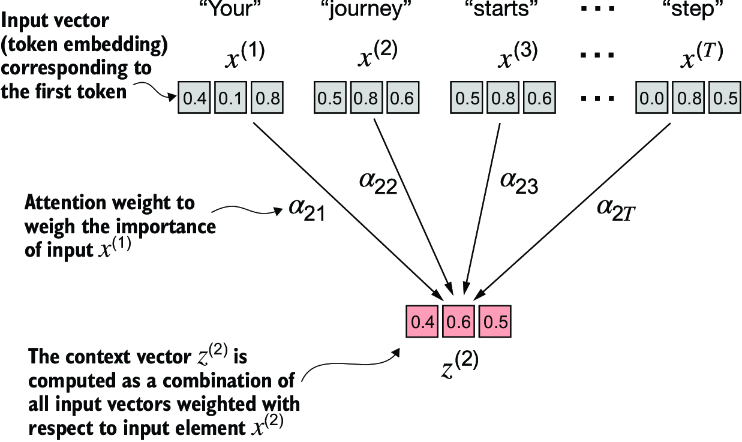


We have sentence : "Your journey starts with one step." we divide into tokens like x1, x2, x3 and so on... Each vector is three dimesional embedding. Lets consider the second embedding vectore that is x2 -> apply self attetnin -> z2 it combine all the information of other vectors like x1, x3 and x4. 

In [1]:
import torch 
from torch import nn
import matplotlib.pyplot as plt 
import numpy as np 

In [2]:
import torch
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

In [5]:
torch.empty(inputs.shape[0])

tensor([0., 0., 0., 0., 0., 0.])

In [3]:
query = inputs[1] # x2 
attention_score_x2 = torch.empty(inputs.shape[0]) # creating an empty array 

for i,n in enumerate(inputs):
    
     # x2 will get mul to eveery other tokens 
     # n willl go through all the val in inputs and it will get mul to query that is x2 
     # for example each element in [0.43, 0.15, 0.89] will get mul to each element in elementwise [0.55, 0.87, 0.66]
     # this will genrate new array then we take the sum of array this will gen our first elment in "attention_score_x2" 
    attention_score_x2[i] = torch.dot(n, query)
                                
    
print(attention_score_x2)

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


#### UNDERSTANDING DOT PRODUCTS

A dot product is essentially a concise way of multiplying two vectors element-wise and then summing the products


In [8]:
res = 0 

for i in range(len(inputs[0])):
    
    res += inputs[0][i] * query[i]
    
print(res)
print(torch.dot(inputs[0],query))

tensor(0.9544)
tensor(0.9544)
